In [1]:
import numpy as np
import pandas as pd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import MultiPolygon
from matplotlib import pyplot as plt
import time
%matplotlib inline

In [2]:
def scale(num):
    #create 14 digits by padding 0's if needed
    num1 = str(abs(num[0]))
    num2 = str(abs(num[1]))
    
    if len(num1) < 15:
        num1 = num1.ljust(15, '0')
    elif len(num1) > 15:
        num1 = num1[:15]
    
    if len(num2) < 15:
        num2 = num2.ljust(15, '0')
    elif len(num2) > 15:
        num2 = num2[:15]
    
    #shift decimal for 8 decimal places
    return np.array([-1.*(float(num1) * (10**5)),-1.*(float(num2) * (10**5))])

def center(coord):
    # coord is an np array containing lat and long
    
    #find mean
    mean = coord.mean()
    
    #center by subtracting the mean
    coord = coord - mean
    return coord

In [3]:
def get_data(filename):
    data = pd.read_csv(filename)
    vertex = data["SHAPE"]
    return vertex

def prep_row(row):
    #pull off 'MULTIPOLYGON ((' leaving one set of parentheses around string
    cleaned = row[16:-3]
    return cleaned # should look like '(lon lat, lon lat,...), (lon lat, lon lat...), (.....)'

def find_multi(row):
    found = False
    if '), (' in row:
        found = True
    return found

def get_poly(data):
#     vertex = data.replace(',', '')
    vertex = data.split(",")
    vertex = [item.strip() for item in vertex ]
    vertex = [(float(item.split(" ")[0]) ,float(item.split(" ")[1])) for item in vertex]
    print np.asarray(vertex)

def get_multi(multi):
    #replace '), (' which separate polygons to ')&(' to be able to split properly
    fxn = multi.replace("), (", "&")
    fxn = fxn.split("&") 
    multi_2d = []
    for i in range(len(fxn)):
        multi_2d.append(get_poly(fxn[i])) 
    #converts to array
    multi_list = np.asarray(multi_2d)
    return multi_list.reshape((len(multi_list), 1))

def parse_shapes(one_row):
    is_multi = find_multi(one_row)
    if is_multi == True:
        prepped = prep_row(one_row)
        prepd_split = get_multi(prepped)
        return (prepd_split)
    else:
        prepped = prep_row(one_row)
        prepd_cleand = get_poly(prepped)
        return (prepd_cleand)

In [22]:
def generate_grid(x, y, cell_num):
    """ Inputs: array with latitude min and latitude max, array with longitude min and longitude max, and number of cells
    Actions: Creates a grid using this data
    Outputs: an array of the x ticks, an array of the y ticks, the x and y widths of a single cell """

    x_min = x[0]
    x_max = x[1]

    y_min = y[0]
    y_max = y[1]

    #Create ticks
    x_s = np.linspace(x_min, x_max, cell_num + 1)
    y_s = np.linspace(y_min, y_max, cell_num + 1)

    #Create grid
    x_coord, y_coord = np.meshgrid(x_s, y_s)

    #length and width of a single cell
    x_shift = np.abs(x_s[1] - x_s[0])
    y_shift = np.abs(y_s[1] - y_s[0])
    return x_coord, y_coord, x_shift, y_shift

In [38]:
def gen_rand_pts(min_lat, min_long, delta_x, delta_y, y_cell, x_cell, rand_num):
    """ Inputs: latitude min, latitude max, longitude min, longitude max, number of x and y cells, number of random points
    Actions: First, it creates random points within the boundaries of a single cell. Then, it translates these random points
    to each cell.
    Outputs: a list of arrays of random points per cell """
    print min_lat, min_long, delta_x, delta_y
    #generate random points of a single cell
    rand_x_grid1 = np.random.uniform(min_lat, min_lat + x_shift, rand_num)
    rand_y_grid1 = np.random.uniform(min_long, min_long + y_shift, rand_num)
    old_grid_pts = np.array(zip(rand_x_grid1, rand_y_grid1)) 
    plt.scatter(rand_x_grid1, rand_y_grid1)
    plt.show()
    
    list_of_pts = []  
    new_grid_pts = np.copy(old_grid_pts)
    for y_tick in range(y_cell):
        for x_tick in range(x_cell):
            new_grid_pts[:, 0] =  old_grid_pts[:, 0] + delta_x * x_tick #shift horizontally
            list_of_pts.append(np.copy(new_grid_pts))
        new_grid_pts[:, 1] += delta_y #shift vertically
    return list_of_pts

-71.14003 42.35827 0.00127499999999 0.000914999999999


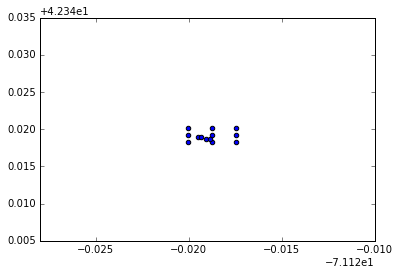

[array([[-71.13950847,  42.35893257],
       [-71.13909189,  42.35871106],
       [-71.1393676 ,  42.35888781],
       [-71.13883535,  42.35873597]]), array([[-71.13823347,  42.35893257],
       [-71.13781689,  42.35871106],
       [-71.1380926 ,  42.35888781],
       [-71.13756035,  42.35873597]]), array([[-71.13950847,  42.35984757],
       [-71.13909189,  42.35962606],
       [-71.1393676 ,  42.35980281],
       [-71.13883535,  42.35965097]]), array([[-71.13823347,  42.35984757],
       [-71.13781689,  42.35962606],
       [-71.1380926 ,  42.35980281],
       [-71.13756035,  42.35965097]])]


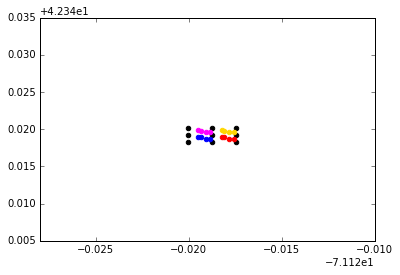

In [43]:
"""Testing the function above"""
x = [ -71.14003, -71.13748]
# x = [0, 1]
y = [42.35827, 42.3601]

x_coord, y_coord, x_shift, y_shift = generate_grid(x, y, 2)
# print x_coord, "\n", y_coord, x_shift, y_shift

# print zip(x_coord.tolist(), y_coord.tolist())


# print x_shift, y_shift

plt.scatter(x_coord, y_coord)

rand_pts = gen_rand_pts(x[0], y[0], x_shift, y_shift, 2, 2, 4)
print rand_pts
plt.scatter(x_coord, y_coord, color="black")
plt.scatter(rand_pts[0][:, 0], rand_pts[0][:, 1], color="blue")
plt.scatter(rand_pts[1][:, 0], rand_pts[1][:, 1], color="red")
plt.scatter(rand_pts[2][:, 0], rand_pts[2][:, 1], color="magenta")
plt.scatter(rand_pts[3][:, 0], rand_pts[3][:, 1], color="gold")
plt.show()

In [26]:
x = [-71.13576963,-71.13612768, -71.13561693,-71.13512698]
y = [42.36160904,42.36105345,42.36127626,42.36185944 ]

def check_bounds(lat, long):
    for i in x:
        if x[i] >= -71.13748 and x[i] <= -71.14003:
            print "TRUE"
        else:
            print "FALSE"
    for j in y:
        if y[i] <= 42.3601 and y[i] >= 42.35827:
            print "TRUE"
        else:
            print "FALSE"

In [ ]:
print def